# Voortoets, Module 3 - Inhoudelijke uitwerking van module 3 in de online toepassing van de voortoets: het bepalen van de reikwijdte van effecten voor de indirecte effectgroepen - Thema Grondwater

Auteurs:
J. Bronders, J. Patyn, I.Van Keer, N. Desmet, J. Vos, W. Peelaerts, L. Decorte & A. Gobin

In opdracht van ANB, 2013

In [274]:
import os
import numpy as np
import matplotlib.pyplot as plt
from etc import newfig, attr
from scipy.signal import lfilter, filtfilt
from scipy.special import k0 as K0
from scipy.integrate import quad, quad_vec

In [270]:
class Dirs:
    """Namespace for directories in project"""
    def __init__(self):
        self.home = '/Users/Theo/Entiteiten/Hygea/2022-AGT/jupyter/'
        self.data = os.path.join(self.home, 'data')
        self.images = os.path.join(self.home, 'images')
    
dirs = Dirs()
os.path.isdir(dirs.data)
os.path.isdir(dirs.images)

True

De stroming Q [m2/d] is gelijk aan

$$Q	=-T\frac{dh}{dx}=N(x - x_L) + Q_L$$

Na integratie
$$h(x)	= h_L + \frac{Q_{L}}{T} (x - x_L) -\frac{N}{2T}(x - x_L)^{2}$$

$$Q_{L}=\frac{T}{x_L - x_R} \left(h_R - h_L + \frac{N}{2 T}(x_R - x_L)^2\right)$$

$$Q_{L}=-\frac{T}{L} \left(h_R - h_L + \frac{N}{2 T}L^2\right)$$


Met deze vergelijkingen kan de stijghoogte en de stroming worden berekend. Analytische uitwerking is niet nodig.

In [ ]:
def get_xRD(xL, xR, xW, N=30):
    """Return x-coordinate of mirror wells for right ditch
    
    Parameters
    ----------
    xL, xR: floats
        x-coordinates of left and right of strip between the two head boundaries
    xW: float
        x-coordinate of the well.
    N: int
        number of mirror wells positions
    """
    d = xR - xW
    x0 = xR + d     
    xRD = [x0]
    for i in range(1, N + 1):
        if i % 2 == 1:
            xRD.append(xL - (xRD[-1] - xL))
        else:
            xRD.append(xR - (xRD[-1] - xR))
    return np.array(xRD)

def get_xLD(xL, xR, xW, N=30):
    """Return x-coordinate of mirror wells for left ditch
    
    Parameters
    ----------
    xL, xR: floats
        x-coordinates of left and right of strip between the two head boundaries
    xW: float
        x-coordinate of the well.
    N: int
        number of mirror wells positions
    """   
    d = (xW - xL)
    x0 = xL - d
    xLD = [x0]
    for i in range(1, N + 1):
        if i % 2 == 1:
            xLD.append(xR - (xLD[-1] - xR ))
        else:
            xLD.append(xL - (xLD[-1] - xL))
    return np.array(xLD)

[0.         0.00046205 0.00092427 ... 0.00182047 0.00090847 0.        ]


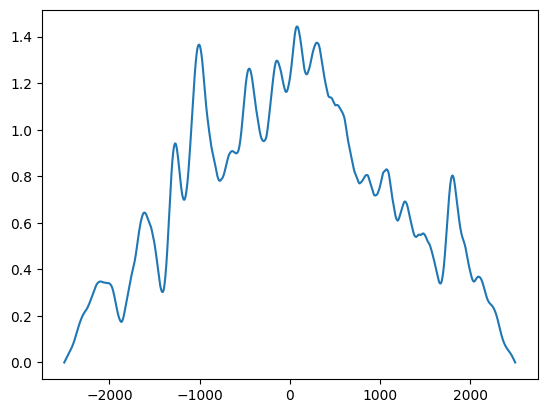

In [177]:
def get_mv(x, L=100, N=3):
    a = 0.5 * (x[-1] - x[0])
    b = 1.0
    xM = np.mean(x)
    y = b ** 2 * (1 - ((x - xM) / a) ** 2)
    z0 = np.random.random(len(x)) - 0.5
    z1 = np.random.random(len(x)) - 0.5
    for i in range(N):
        z0 = lfilter(np.ones(L) / L, 1., z0)
        z1 = lfilter(np.ones(L) / L, 1., z1)
    mv = (z0 + z1[::-1]) * y * 8 + y
    return mv
    
print(get_mv(x))
plt.plot(x, get_mv(x))

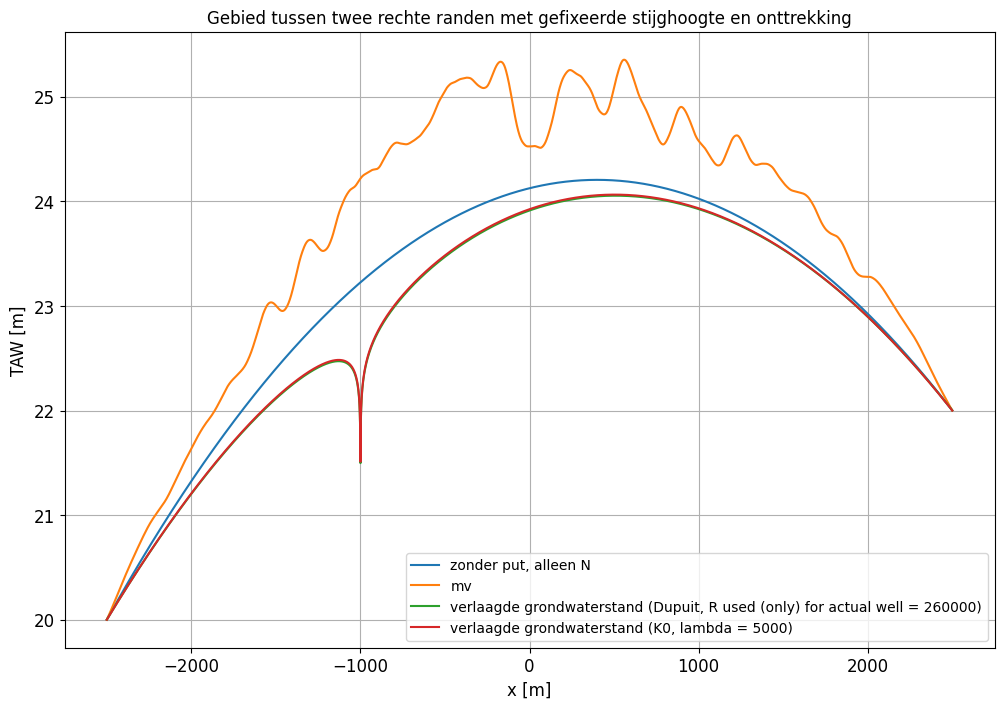

In [387]:
N, T = 0.001, 20 * 50
Q = -1200 # m3/d

xL, xR, hL, hR = -2500., 2500., 20., 22.

x = np.linspace(xL, xR, 5000)
y = np.zeros_like(x)

xM = 0.5 * (xL + xR)
xW, yW = xM - 1000., 0.

L = xR - xL
def h_1d(x, N=None, T=None, xL=None, xR=None, hL=None, hR=None):
    """Return head for 1D flow between xL and xR for given hL and hR and N"""
    QL = -T / (xR - xL) * (hR - hL + N / (2 * T) * (xR - xL) ** 2)
    h = hL - QL / T * (x - xL) - N / (2 * T) * (x - xL) ** 2
    return h

h = h_1d(x, N=N, T=T, xL=xL, xR=xR, hL=hL, hR=hR)

ax = newfig("Gebied tussen twee rechte randen met gefixeerde stijghoogte en onttrekking", "x [m]", "TAW [m]")

ax.plot(x, h, label="zonder put, alleen N")
ax.plot(x, get_mv(x) + h, label='mv')


# Get the well positions
M = 51
xLD = get_xLD(xL, xR, xW, N=M)
xRD = get_xRD(xL, xR, xW, N=M)
yld = yrd = 0.

# The real (actual well:
FQ = -Q / (2 * np.pi * T)
r = np.sqrt((x - xW) ** 2 + (y - yW) ** 2)

# Use a large big R to limit the effect of log of the actual well going to infinity
R = 0.5 * (np.sqrt((xW - xLD[-1]) ** 2 + (yW - yld) ** 2) + np.sqrt((xW - xRD[-1]) ** 2 + (yW - yW) ** 2))
s0 = FQ * np.log(r / R)

# We can also use leaky aqufier which ensures the drawdown approaches zero at infinity
lamb = 5000.
s1 = -FQ * K0(r / lamb)

# Add the effect of all the mirror wells
for i, (xld, xrd) in enumerate(zip(xLD, xRD)):
    sign = (-1) ** i
    rRD = np.sqrt((x - xld) ** 2 + (y - yld) ** 2)
    rLD = np.sqrt((x - xrd) ** 2 + (y - yrd) ** 2)    
    s0 += -sign * FQ * np.log(rRD) # Don't need R here, because it cancels out
    s0 += -sign * FQ * np.log(rLD) # Don't need R here, because it cancels out
    s1 += +sign * FQ * K0(rRD / lamb) # Don't need R here, because it cancels out
    s1 += +sign * FQ * K0(rLD / lamb) # Don't need R here, because it cancels out
    # ax2.plot([xrd, xrd], [0, sign * dy], 'r')
    # ax2.plot([xld, xld], [0, sign * dy], 'b')
    
ax.plot(x, h + s0, label=f"verlaagde grondwaterstand (Dupuit, R used (only) for actual well = {R:.0f})")
ax.plot(x, h + s1, label=f"verlaagde grondwaterstand (K0, lambda = {lamb:.0f})")
ax.legend()

plt.gcf().savefig(os.path.join(dirs.images, "puntbron_dupuit_strip_A.png"), transparent=True)

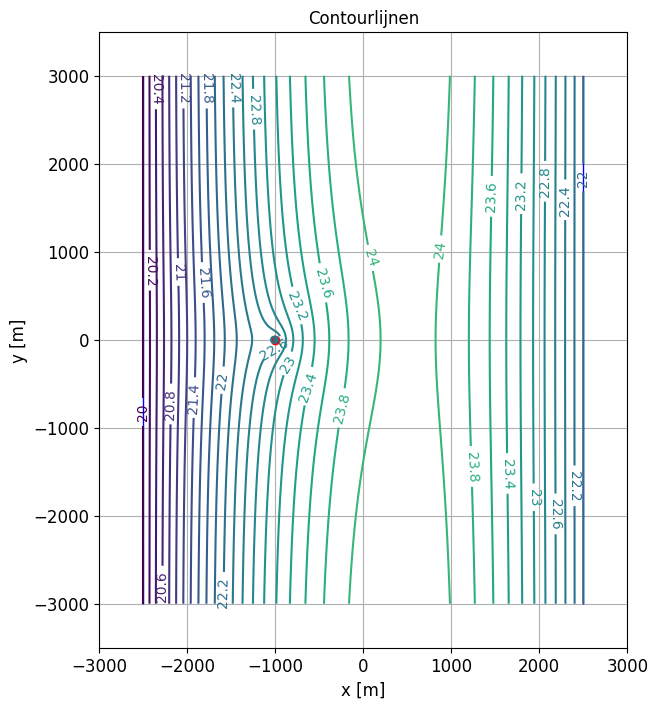

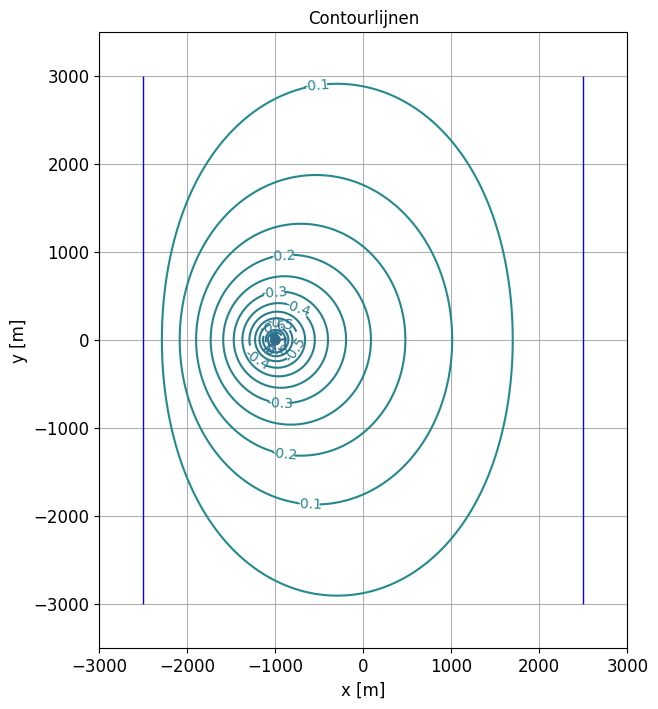

In [272]:
# Grondwaterstanden contourlijnen
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith('0'):
        s = f"{x:.0f}"
    return f"{s}"


y = np.linspace(-3000, 3000, 601)
X, Y = np.meshgrid(x, y)

ax = newfig("Contourlijnen", "x [m]", "y [m]")
ax.plot(xW, yW, 'ro') # Well
ax.vlines(x[[0, -1]], y[0], y[-1], color='b', lw=1) # The canals

ax.set_xlim(x[0] - 500, x[-1] + 500)
ax.set_ylim(y[0] - 500, y[-1] + 500)
ax.set_aspect(1.0)

lamb = 20000. # Fixtieve zeer hoge spreidingslengte
r = np.sqrt((X - xW) ** 2 + (Y - yW) ** 2)

# Using K0 to make sure dd goes to zero for very large r
# With log, we don't get zero drawdown along both canals, only near y=0
s = -FQ * K0(r  / lamb)

# Add the effect of all the mirror wells
for i, (xld, xrd) in enumerate(zip(xLD, xRD)):
    sign = (-1) ** i
    rRD = np.sqrt((X - xld) ** 2 + (Y - yld) ** 2)
    rLD = np.sqrt((X - xrd) ** 2 + (Y - yrd) ** 2)    
    s += sign * FQ * K0(rRD / lamb)
    s += sign * FQ * K0(rLD / lamb)
    ax.plot(xld, 0, 'r.')
    ax.plot(xrd, 0, 'b.')
    
levels = hL + np.arange(0, 6.2, 0.2)
CS = ax.contour(X, Y, s + h[np.newaxis, :], levels=levels)
ax.clabel(CS, CS.levels, fmt=fmt, fontsize=10)

plt.gcf().savefig(os.path.join(dirs.images, "puntbron_dupuit_strip_B.png"), transparent=True)

ax = newfig("Contourlijnen", "x [m]", "y [m]")
ax.plot(xW, yW, 'ro') # Well
ax.vlines(x[[0, -1]], y[0], y[-1], color='b', lw=1) # The canals

ax.set_xlim(x[0] - 500, x[-1] + 500)
ax.set_ylim(y[0] - 500, y[-1] + 500)
ax.set_aspect(1.0)
levels = np.arange(-3, 3.2, 0.05)
CS = ax.contour(X, Y, s, levels=levels)
ax.clabel(CS, CS.levels, fmt=fmt, fontsize=10)

plt.gcf().savefig(os.path.join(dirs.images, "puntbron_dupuit_strip_C.png"), transparent=True)


# Bruggeman, een gebied gaat over in een ander gebied.

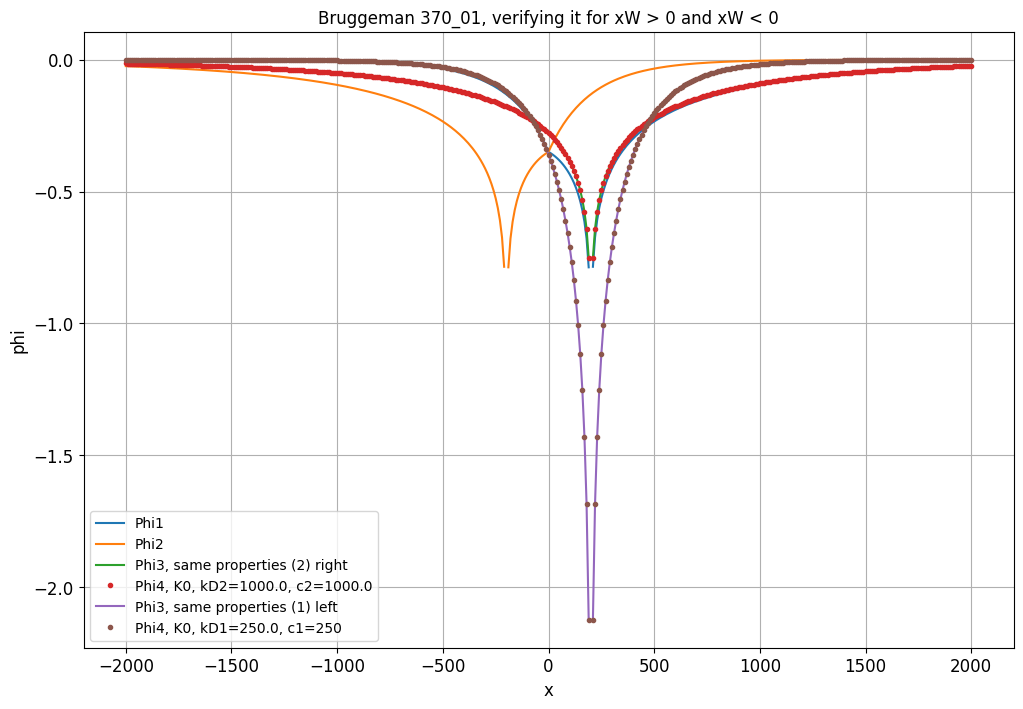

In [344]:
import numpy as np
from scipy.integrate import quad
from scipy.special import k0 as K0  # Modified Bessel function of the second kind

def A(alpha, a, kD1, kD2, L1, L2):
    return np.exp(-a * np.sqrt(alpha ** 2 + 1 / L2 ** 2)) / (
        kD1 * np.sqrt(alpha ** 2 + 1 / L1 ** 2) + kD2 * np.sqrt(alpha ** 2 + 1 / L2 ** 2)
    )

def arg1(alpha, a, x, y, kD1, kD2, L1, L2):
    return A(alpha, a, kD1, kD2, L1, L2) * np.exp(x * np.sqrt(alpha ** 2 + 1 / L1 ** 2)) * np.cos(y * alpha)

def arg2(alpha, a, x, y, kD1, kD2, L1, L2):
    return A(alpha, a, kD1, kD2, L1, L2) * np.exp(-x * np.sqrt(alpha ** 2 + 1 / L2 ** 2)) * np.cos(y * alpha)

def brug370_01(X, Y, xw, kD1, kD2, c1, c2):
    """Problem 370_01 from Bruggeman(1999)
    
    Parameters
    ----------
    X, Y: floats or arrays
        x, y coordinates
    xw: float
        Well x-coordinate (y = 0)
    kD1, kD2, c1, c2: floats
        Transmissivities and resistances for x < 0 and for x > 0
    """
    # Convert scalars to arrays for vectorized computation
    X = np.atleast_1d(X)
    if np.isscalar(Y):
        Y = Y * np.ones_like(X)
    assert np.all(X.shape == Y.shape), f"X.shape {X.shape} != Y.shape {Y.shape}"

    # If xw < 0, transform the problem and reuse function
    if xw < 0:
        X, Y, Phi = brug370_01(-X, Y, -xw, kD2, kD1, c2, c1)
        return -X, Y, Phi

    # Compute length scales
    L1, L2 = np.sqrt(kD1 * c1), np.sqrt(kD2 * c2)
    a = xw  # Well x-coordinate
    
    # Create output array for Phi
    Phi = np.full_like(X, np.nan, dtype=np.float64)

    # Mask for points where x != a
    mask_x_a = X != a
    mask_x_neg = X < 0
    mask_x_pos = ~mask_x_neg
    
    # Evaluate `phi` for x < 0
    if np.any(mask_x_neg):
        valid = mask_x_a & mask_x_neg
        Phi[valid] = np.vectorize(
            lambda x, y: Q / np.pi * quad(arg1, 0, np.inf, args=(a, x, y, kD1, kD2, L1, L2))[0]
        )(X[valid], Y[valid])

    # Evaluate `phi` for x > 0    
    if np.any(mask_x_pos):
        valid = mask_x_a & mask_x_pos
        Phi[valid] = np.vectorize(
            lambda x, y: (
                Q / (2 * np.pi * kD2) * (K0(np.sqrt((x - a) ** 2 + y ** 2) / L2) -
                K0(np.sqrt((x + a) ** 2 + y ** 2) / L2))
                + Q / np.pi * quad(arg2, 0, np.inf, args=(a, x, y, kD1, kD2, L1, L2))[0]
            )
        )(X[valid], Y[valid])

    return X, Y, Phi

kD1, kD2, c1, c2 = 250., 1000., 250, 1000.
L1, L2 = np.sqrt(kD1 * c1), np.sqrt(kD2 * c2)
a = 200.

ax = newfig("Bruggeman 370_01, verifying it for xW > 0 and xW < 0", "x", "phi")
x = np.linspace(-2000, 2000, 401)
y = 0
xw = 200.
X, Y, Phi1 = brug370_01(x, y, xw, kD1, kD2, c1, c2)
X, Y, Phi2 = brug370_01(x, y, -xw, kD2, kD1, c2, c1)
X, Y, Phi3 = brug370_01(x, y, xw, kD2, kD2, c2, c2)
Phi4 = Q / (2 * np.pi * kD2) * K0(np.abs(x - xw)   / np.sqrt(kD2 * c2))
X, Y, Phi5 = brug370_01(x, y, xw, kD1, kD1, c1, c1)
Phi6 = Q / (2 * np.pi * kD1) * K0(np.abs(x - xw)   / np.sqrt(kD1 * c1))
if X.ndim == 1:
    ax.plot(X, Phi1, label="Phi1")
    ax.plot(X, Phi2, label="Phi2")
    ax.plot(X, Phi3, label="Phi3, same properties (2) right")
    ax.plot(X, Phi4, '.', label=f"Phi4, K0, kD2={kD2}, c2={c2}")
    ax.plot(X, Phi6, label="Phi3, same properties (1) left")
    ax.plot(X, Phi6, '.', label=f"Phi4, K0, kD1={kD1}, c1={c1}")
else:
    CS = ax.contour(X, Y, Phi1, levels=levels)
    ax.clabel(CS, levels=CS.levels, fmt="{:.2f}")
    
ax.legend()


# Example Bruggeman 370_01

A higher area along an are with a drainage resistance

$$ h = h_L - \frac N {2 * T} (x - x_L)^2 - \frac{Q_L}{T}(x - x_L) $$

Op overgang naar het gebied met drainageweerstand rechts van $x_R$ moet $Q_R# continu zijn
$$ Q_L + N L = h_R \frac T \lambda$$
Zodat
$$h(x_R) = h_R + (Q_L + N L) \frac \lambda T$$

Ingevuld levert dit $Q_L$ op

$$Q_L = \frac{ -T \left( h_R - h_L + \frac{N}{2 T} (x_R - x_L)^2 +\frac{N}{T} \lambda (x_R-x_L) \right)}
{\lambda + x_R - x_L}$$

$$Q_L = \frac{ -T \left( h_R - h_L + \frac{N}{2 T}L^2 +\frac{N}{T} \lambda L \right)}
{\lambda + L}$$

$$Q_L = \frac{ -\frac{T}{L} \left( h_R - h_L + \frac{N}{2 T}L^2 +\frac{N}{T} \lambda L \right)}
{1 + \frac{\lambda}{L}}$$


array([-3.01886792, -3.01786792, -3.01686792, ...,  0.07114763,
        0.07091087,  0.07067489])

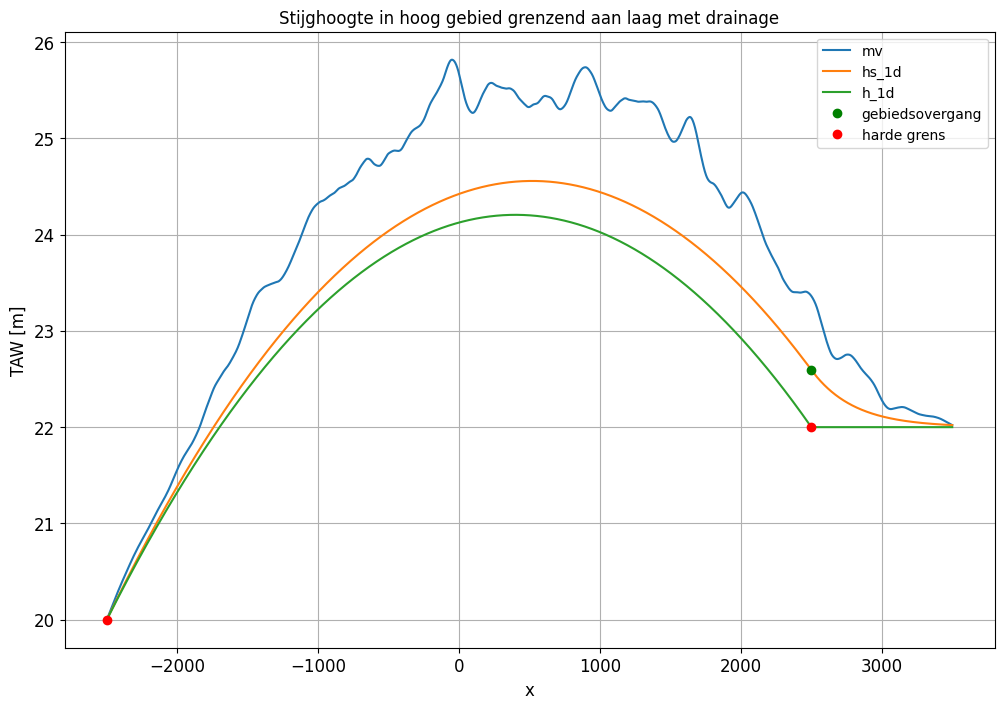

In [ ]:
N, T = 0.001, 20 * 50
Q = -1200 # m3/d

xL, xR, hL, hR = -2500., 2500., 20., 22.
lamb = 300
x = np.linspace(xL, xR + 1000, 6001)
y = np.zeros_like(x)

xM = 0.5 * (xL + xR)
xW, yW = xM - 1000., 0.


X = np.arange(xL, xR + 1001, 10)
h = np.zeros_like(X)

def Q(x, N=None, T=None, xL=None, xR=None, hL=None, hR=None, lamb=None, eps=1e-6):
    L = xR - xL
    QL = -T / L  * (hR - hL + N / (2 * T) * L ** 2 + N / T * lamb * L) / (1 + lamb / L)
    
    x = np.atleast_1d(x)
    Q = np.zeros_like(x)
    Q[x < xR] = QL + N * (x[x < xR] - xL)
    Q[x >= xR] = (QL + N *(xR - xL)) * np.exp(-(x[x >=xR] - xR) / (lamb + eps))
    if len(Q) == 1:
        Q = Q[0]
    return Q

def hs_1d(x, N=None, T=None, xL=None, xR=None, hL=None, hR=None, lamb=None, eps=1e-6):  
    QL = Q(xL, N=N, T=T, xL=xL, xR=xR, hL=hL, hR=hR, lamb=lamb)
    dhR = (QL + N * (xR - xL)) * lamb / T    
    x = np.atleast_1d(x)
    h = np.zeros_like(x)
    mask_L = x < xR
    mask_R = ~mask_L
    h[mask_L] = hL - QL / T * (x[mask_L] - xL)  - N / (2 * T) * (x[mask_L] - xL) ** 2
    h[mask_R] = hR + dhR * np.exp(-(x[mask_R] - xR) / (lamb + eps))
    if len(x) == 1:
        h=h[0]
    return h

kwargs = {'N': N, 'T': T, 'xL': xL, 'xR': xR, 'hL': hL, 'hR': hR}


ax = newfig("Stijghoogte in hoog gebied grenzend aan laag met drainage", "x", "TAW [m]")
ax.plot(x, get_mv(x) + hs_1d(x, lamb=lamb, **kwargs), label='mv')
ax.plot(x, hs_1d(x, lamb=lamb, **kwargs), label='hs_1d')
ax.plot(x, hs_1d(x, lamb=0., **kwargs), label='h_1d')
hxL, hxR = hs_1d(xL, lamb=lamb, **kwargs), hs_1d(xR, lamb=lamb, **kwargs)

# Plot the boundary locations
ax.plot([xR], [hxR], 'go', label="gebiedsovergang")
hxL, hxR = hs_1d(xL, lamb=0., **kwargs), hs_1d(xR, lamb=0., **kwargs)
ax.plot([xL, xR], [hxL, hxR], 'ro', label="harde grens")
ax.legend()

Q(x, lamb=lamb, **kwargs)

## Berekening wijziging grondwaterstand per type bron (primair effect)

### Puntbronnen

Bepaling van de grondwaterstandsverandering ten gevolge van puntbronnen (pompputten).

De formule van Duipuit geldt voor stationaire verlaging in een pakket met horizontale bodem, uniforme doorlatendheid en een rand op afstand $R$ waarop of waarbuiten geen verlaging meer optreedt. Alleen wanneer in het beschouwde gebied een neerslagoverschot $N$ wordt via drainage of een dicht stelsel van waterlopen wordt afgevoerd en deze afvoer door de onttrekking wegvalt, kan men stellen dat deze door de verlaging weggevallen drainage ten goede komt aan het grondwater. In dat geval is de formule van Verruijt toepasbaar, althans tot hoogstens een afstand waarop het ingevangen neerslagoverschot gelijk is aan de onttrekking. De afstand tot waar de formule van Verruijt geldt is zelfs kleiner, en reikt namelijk niet verder dan de afstand waarop de afvoer door de drainage juist gelijk is aan nul. Daarbuiten voert de drainage of het oppervlaktestelsel nog steeds een deel van het neerslagoverschot af en geldt feitelijk de formule van De Glee, waarin het watervoerend pakket wordt gevoedt in evenredigheid met de verlaging, waarbij de drainageweerstand de evenredigheidsconstante vormt. De formule van Verruijt en die van De Glee worden op deze grens aan elkaar geknoopt. De combinatie heet de Formule van Blom, wat geen formule is maar twee formules die met elkaar zijn verbonden op de afstand waarop de drainage juist gelijk aan nul is. Dit is waar de verlaging gelijk is aan $N c$ met $N$ het neerslagoverschot eventueel vermeerderd met kwel en $c$ de drainageweerstand.

De formule van Dupuit geldt wanneer er geen terugkoppeling is tussen verlaging en voeding van het watervoerend pakket. Dit is het geval in een gebied met weinig of geen oppervlaktewater of drainages. De formule van Dupuit kan natuurlijk op een bepaalde afstand overgaan in de formule van Verruijt en nog weer verder van de put in die van De Glee. Dit is afhankelijk van de grondwaterafvoer naar het oppervlak in het beschouwde gebied.

Het is intussen best ingewikkeld om 3 analytische formules aan elkaar te knopen, zodat uit praktische overwegingen ofwel Dupuit en De Glee danwel Verruijt en De Glee aan elkaar kunnen worden geknoopt afhankleijk van het gebied waarin men verkeert.

Het is intussen zeer de vraag in hoeverre een stationaire, jaargemiddelde situatie en verlaging relevant is voor de te beschermen SBZ. Immers de situatie in de winter met neerslag zonder vardamping en de zomer met een neerslagtekort zijn zeer verschillend. In de zomersituatie met neerslagtekort zullen drainages en waterlopen geheel droog kunnen raken. Onder zulke omstandigheden beweegt het grondwateroppervlak geheel vrij van het drainage- en het slotenstelsel. De verlaging zal zich onder zulke omstandigheden dan ook voortdurend uitbreiden overeenkomstig de formule van Theis. Dit gaat door totdat als gevolg van het neerslagoverschot in het najaar de grondwaterstanden weer zover zijn gestegen dat drainages en of sloten weer grondwater, in feite neerslagoverschot plus mogelijk kwel, gaan afvoeren. Men zou daarom moeten stellen dat voor de berekening van de verlaging in de zomer periode in het algemeen uitgegaan moet worden van de formule van Theis. Deze bepaalt de maximale uitbreiding aan het eind van de zomer. Deze invloedsstraal krimpt vervolgens in de periode met neerslagoverschot, waarvoor een stationaire berekening veel meer voor de hand ligt. Het hierbij te gebruiken neerslagoverschot kan 1 tot 2 mm/dag zijn.

De berekening van de verlaging met de stationaire formules zijn derhalve eerder geschikt voor het berekenen van de verlaging in de winter en de formule van Theis voor niet-staionaire verlaging voor de berekening van de verlaging aan het eind van de zomer. Hierbij moet een keuze worden gemaakt voor de duur van de zomer. Hiervoor kan een prakische grens van 100 dagen worden gekozen.

De in het rapport gebruikte formules van Dupuit en Verruijt houden beide rekening met de afname van de natte dikte van het watervoerende pakket als gevolg van de verlaging. Deze formules zijn daarom niet-lineair. Echter, de extra verlaging als gevolg van de afname van de effectieve dikte van het watervoerende pakket is alleen relevant in de nabijheid van de pompput. Voor het berekenen van de invloed op een SBZ op enige afstand is het effect niet van belang, waardoor de formules van Dupuit en Verruijt met vaste pakketdikte eveneens toepasbaar zijn. De formules van De Glee en van Theis hebben zelf geen variant met variabele laagdikte.

De drainageweerstand $c$ [d] is een belangrijke factor bij de bepaling van de invloedsstraal in de stationaire situatie. Deze is gelijk aan $c = \overline{h} / N$ waarbij $\overline{h}$ de gemiddelde stijghoogte is boven het drainageniveau danwel het peil in het stelsel van waterlopen. De verlaging waarbij de formule van Verruijt overgaat in die van De Glee is $\overline{h} = N c$.

Voor de niet-stationaire situatie in de zomer, zodat de formule van Theis geldt, is de invloedsstraal
$$ R = \sqrt{\frac{2.25 \, kD\,t}{S} }$$

De genoemde analytische formules zijn allemaal axiaal-symmetrisch. Dit impliceert dat zij alleen van toepassing zijn wanneer de omstandigheden in alle richtingen hetzelfde zijn waardoor de verlagingslijnen cirkels vormen. Dit is in de werkelijkheid lang niet overal het geval. Bijvoorbeeld wanneer zich aan een of meer zijden belangrijke waterlopen bevinden of wanneer de ingreep plaats vindt in een overgangsgebied, bij bijvoorbeeld een droog zandgebied aan een zijde dat aan de andere zijde geleidelijk overgaat in een natter gebied met een steeds dichter stelsel van waterlopen en of drainages. De situatie wordt dan al snel te complex voor een Voortoets die terecht gebruiksvriendelijkheid, robuustheid en daarmee eenvoud op de voorgrond stelt. Op zulke situaties zijn axiaal-summetrische formules alleen in uitzonderingen toepasbaar door randvoorwaarden te simuleren middels superpositie met spiegelputten. In de meest gevallen zullen zij feitelijk niet (goed) toepasbaar zijn. De formueles voor stationaie verlaging geven wanneer toegepast onder de geschetste omstandigheden in overgangsgebieden bovendien een onderschatting van de werkelijke verlaging. Voor de niet-stationaire verlaging volgens Theis is dit niet het geval. Het is kortom van belang te onderkennen wanneer de axiaal-symmetrische analytische formules wel of juist niet toepasbaar zijn.

# Voorbeeld van de toepassing van formules voor stationaire verlaging en vergelijking met de niet-stationaire verlaging volgens Theis

## Oppervlaktebron bouwput

Bemaling voor een bouwput heeft tot doel een bepaalde verlaging van de grondwaterstand binnend de bouwput te realiseren. Dus niet het onttrokken grondwater maar de te realiseren verlaging binnen de bouwput is hier het doel. De initiatiefnemer wordt nu gevaagd het onttrekkingsdebiet op te geven. Hij kan dit alleen in redelijkheid doen, wanneer hij de bouwput al met grondwaterformules of een grondwatermodel heeft doorgerekend. Het is bovendien de vraag op het opgegeven debiet juist is. In plaats van de verantwoordlijkheid voor het opgeven van het debiet althans voor de Voortoets bij de initiatiefnemer te leggen, kan dit ook binnen de Voortoets worden berekend op basis van de verlaging die de initiatiefnemer wenst te bereiken. Alleen in dat geval zal het berekende effect op de grondwaterstand consistent zijn met de laageigenschappen die in de Voortoets voor de berekening worden gebruikt. Eventueel kun de berekening worden gebruikt om het opgegeven debiet te controleren. Maar zelf uitrekenen heeft mogelijk de voorkeur in verband met de vereiste consistentie en de aanvraag en de beoordeling daarvan onafhankelijk maken van wat de initiatiefnemer opgeeft.

Wanneer de bouwput opgevat kan worden als een cirkelvorige verlaging, iets dat op enige afstand van de bouwput praktisch altijd het geval zal zijn, kan de situatie buiten de bouwput met een enkele put in het centrum van de bouwput worden berekend. Voor de verlaging buiten de bouwput maakt het niet uit of de bemaling wordt berekend met een onttrekkringsscherm langs de bouwput of met een enkele put in de bouwput. Dit is exact het geval voor de formules voor stationaire verlaging en na enige tijd ook voor de formules voor tijdsafhankelijke verlaging.

Het staat de intiatiefnemer natuurlijk vrij om de bouwput als een enkele cirkelvormige verlaging te beschouwen of als een combinatie van meerdere cikelvormige verlagingen.

Voor een bouwput geldt net als voor een puntonttrekking dat de effecten afhankelijk zijn van het jaargetijde. Om deze reden zou voor een bemaling in de zomer dan ook het beste niet-stationair het effect op de grondwaterstand kunnen worden berekend met de formule van Theis, terwijl voor de wintersituatie eerder de formules van Dupuit, Verruijt of Blom toepasbaar zullen zijn. Opnieuw is de vraag wat de onttrekkingsduur moet zijn om de zomersituatie te berekenen. Van mei t/m september, de periode met verdampingsoverschot is 150 dagen. In de huidige Voortoets wordt hier een periode van 100 dagen (ruim 3 maanden) voor aangehouden.

# Lijn- en sleufonttrekkingen en andere lijnbronnen

Lijn of sleufonttrekkingen associeren met met bemalingen voor bijvoorbeeld aanleg van leidingen waarvoor ontgraven moet worden tot beneden de watertafel. Deze   lijnvormige verlagingen hebben een aanzienlijke lengte en verplaatsesn in de tijd naarmate de werkzaamheden vorderen. Kenmerkend is hun lengte en de onttrekking met vele kleine bemalingsbronnen op enkele tot hoogstens enkele tientallen meters onderlinge afstand, die zijn aansloten op een vacuümpomp.

Andere lijnbronnen zijn sloten waarvan het peil wordt veranderd. Zulke peilveranderingen zijn een strikt andere situatie, maar de formules voor het berekenen van de grondwaterstanden zijn dezelfde.

Een eenvoudige formule van de verlaging is een variant van Dupuit, Verruijt of Blom voor de stationaire situatie. Deze kunnen worden toegepast, maar vergen een keuze ten aanzien van de randvoorwaarde, de afstand waarop de verlaging nul blijft, of waarop de verlaging het omringende oppervlaktewater droog trekt. Deze keuzen zijn lastig te maken, waarom dan ook meestal in de praktijk en in de huidige versie van de Voortoets de tijdsafhankelijke verlaging door de sleufonttrekking wordt berekend, temeer daar zulke voor werkzaamheden uitgevoerde bemalingen sowieso in de tijd beperkt zijn. Dit is uiteraard anders bij permanente peilveranderingen.
De niet-stationaire verlagign door onttrekking langs een oneindig lange lijn is
$$h(x) = h_0 \, \mathtt{erfc}\left(x \sqrt{\frac{S_y}{4 kD t}}{}\right)$$

$$q(x t) = h_0 \, kD\, \frac{2}{\pi}\,\exp\left(-\frac{x^2 S_y}{4 kD t}\right)\sqrt{\frac{S}{4 kD t}}=h_0 \, \sqrt{\frac{kD S}{\pi t}} \exp\left(\frac{x^2 S}{4 kD t}\right)$$
$$q(0, t) = \sqrt{\frac{kD S}{\pi t}}$$

Deze formule houdt geen rekening met de afname van de dikte van het watervoerend pakket als gevolg van de verlaging. Dit hoeft niet erg te zijn, omdat de formule een bovengrens oplevert voor het onttrokken debiet en dus voor de verlaging op afstand van de sleuf. Ook houdt de fromule geen rekening met de lengte van de sleuf, waardoor de uitstraling van de verlaging naar beide einden van de sleuf toe minder wordt. Hier geen rekening mee houden leidt dus eveneens tot een bovengrens van de verlaging. In de praktijk kan de verlaging die met deze formule wordt berekend aan het einden van de sleuf worden gevormd door dezelfde verlaging aan beide zijden van de sleuf met cirkels met elkaar te verbinden.

Voor de duur van de ingreep geldt de echte tijdsduur tot een maximum van 365 dagen, wat als conservatief wordt beschouwd.

Evenals voor de pompputten en bouwputten zou hier voor de winterperiode een stationaire verlaging kunnen worden berekend met de eendimensionale versie van Verruijt en De Glee vanaf het punt waar de verlaging gelijk is aan $N c$, de afstand waarop de afvoer door de sloten juist nul is, terwijl voor de zomer de niet-stationaire situatie aangehouden zou kunnen worden met een duur gelijk aan de lengte van de zomer waarin gemiddelde een verdampingsoverschot aanwezig is. Voor het berekenen van een stationaire wintersituatie is een neerslagoverschot en een drainageweerstand noodzakelijk.

## Vlakdekkende drainage (drainage met parallelle drains)

Het gaat erom de invloed van de drainage buiten het te draineren terrein. De verlaging binnen het terrein wordt niet beschouwd. Onder deze uitgangspunten kunnen dezelfde lijn- of sleufformules worden toegepast die hiervoor al zijn besproken, waarbij als locatie de randen van het te draineren terrein worden aangeduid.

De terrein of gebiedsdrainage zal mogelijk alleen in het natte halfjaar werken, wanneer de grondwaterstanden normaliter hoog oplopen. In dat geval is alleen een stationare berekening voor de wintersituatie nodig. De invloed op de zomer bestaat dan uit een grondwaterstand die aan het begin van de zomer is verlaagd door de drainage, waardoor het grondwaterverloop gedurende de zomer verlaagd blijft ten opzichte van de oorspronkelijke situatie. In een kwelgebied kan een drainage ook gedurende de zomer grondwater afvoeren, waardoor het grondwater voortdurend is verlaagd tot het drainageniveau. De afvoer van de drainage ademt in dat geval mee met het verloop van het neerslagoverschot.

Voro de stroming vanaf de waterscheiding, 4x=0$, dus waar het verhang gelijk is aan nul geldt
$$ q -kh\frac{dh}{dx}= N x$$

Na integratie
$$ h^2 = -\frac{N}{k} x^2 + C$$
De integratie constante volgt uit de eis dat voor $x=B$ de waterdiepte in de aquifer gelijk is aan $H$. Na invulling levert dit
$$h^2 - H^2 = \frac N k (B^2 - x^2)$$

De maximale waterdiepte in de aquifer voor $x=0$, met $h_0^2 - H^2 = (h_0 - H)(h_0 + H) = \Delta h (\Delta h + 2 H)$ volgt

$$B^2 = \frac k N \Delta h (\Delta h + 2 H)$$

of

$$ B = \sqrt{\frac k N (2 H \, \Delta h + \Delta h^2)} $$

De formule in Bonders et al. (2013) geeft zonder afleiding is

$$ B = \sqrt{L^2 + \frac k N {2 H \, \Delta h + \Delta h ^2}} - L$$

en is delzelfde behalve de variabele $L$, de breedte van het te draineren gebied. Zowel wanneer $L$ in deze formule naar nul of naar oneindig gaat, gaat de formule over in de hierboven afgeleide versie zonder $L$. De variabele $L$ aangeduide als de breedte van het gebied waar geen verlaging (door de drainage?) optreedt heeft geen basis in de fysica van de grondwaterstroming. In werkelijkheid rijkt de verlaging tot $x=B4 indien de verlaging het neerslagoverschot naar de verlaagde sloot afleidt of tot een randvoorwaarde verder naar rechts, waar de grondwatestand wordt gefixeerd. In dat laatste geval, ook omdat de maximale verlaging bij de sloot $\Delta h << H$, kan de verlaging eenvoudig lineair worden genomen tussen die bij de sloot en nul bij de lijn waar de grondwaterstand is gefixeerd

$$ h - H = \Delta h \, \frac{x-L}{L} $$




De formule voor de afstand $B$ waarover de watertafel is verlaagd wordt door Bonders et al. opgegeven als

$$ (B + L)^2 = \frac{2 kD \Delta h + k \Delta h^2}{N} + L^2$$

Ik heb nog even geen idee waar deze formule precies vandaan komt.




